#### Requires
    - Torch
    - numpy
    - matplotlib
    - Gpytorch ; pip install gpytorch
    - Botorch ; pip install botorch


In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
from botorch import fit_gpytorch_model

%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from botorch.acquisition.analytic import ExpectedImprovement
from torch.distributions import Normal

In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA', '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']
# cool_colors = sns.color_palette("Set2")

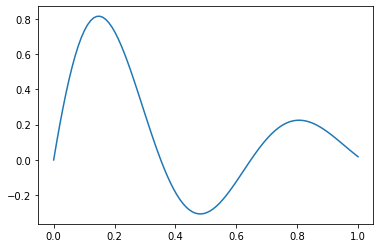

In [3]:
def f(x):
    return x * torch.exp(-4*x) + torch.sin(3*x*math.pi)*torch.exp(-2* x)# + torch.atan(0.7*math.pi*x)#* torch.exp(-2*x) + 0.3 * torch.sin(3*math.pi*x)
#torch.sin(x * (3.2 * math.pi)) * torch.exp(-1.0*x) * np.cos(x*math.pi) + 0.9*torch.exp(-8*(x - 0.4) ** 2)# + np.exp(-x)
#     return torch.exp(-6*(x - 0.2) ** 2)# + np.exp(-x)


plt.figure()
x = torch.linspace(0, 1, 100)
plt.plot(x, f(x))

In [4]:
## Underlying true ('ground') objective
ground_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
# ground_y = f(ground_x)
ground_y = f(ground_x)# torch.sin(ground_x * (2 * math.pi)) * torch.exp(-0.1 * ground_x) - (ground_x - 0.2) ** 2

In [5]:
# Generating initial training data

torch.manual_seed(1) # seed for reproducibility
# Training data 5 points selected 
train_x = torch.tensor([0.01, 0.25, 0.45, 0.6, 0.93])
# True function is sin(2*pi*x) with Gaussian noise
train_y = f(train_x)# np.sin(train_x * (2 * math.pi)) * np.exp(-0.1 * train_x) - (train_x - 0.) ** 2 #+ torch.randn(train_x.size()) * math.sqrt(0.02)
# train_y = np.sin(train_x * (2 * math.pi)) * np.exp(-0.1 * train_x) - 4* (train_x - 0.2) ** 2

In [6]:
# simple GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = 1e-4 # sets the value to zero
likelihood.noise_covar.raw_noise.requires_grad = False # optimizer won't optimize noise hyper-parameter.
model = ExactGPModel(train_x, train_y, likelihood)

In [7]:
# Fitting of the model with training set
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
# fit_gpytorch_model(mll)

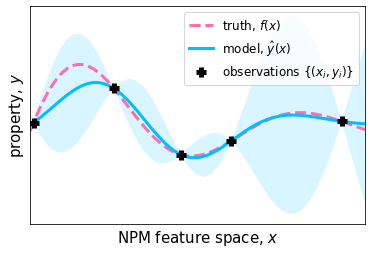

In [8]:
# Plotting Figure 3 in the paper
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    plt.scatter(train_x.numpy(), train_y.numpy(), marker="+", color="k", label='observations $\{(x_i, y_i)\}$', s=95, zorder=2000, lw=5)
    plt.plot(ground_x.numpy(), ground_y.numpy(), linestyle="--", color=cool_colors[2], label='truth, $f(x)$', lw=3)
    # Plot predictive means as blue line
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), color=cool_colors[0], label='model, $\hat{y}(x)$', lw=3)
    # Shade between the lower and upper confidence bounds
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.15, color=cool_colors[0], edgecolor="none")
#     plt.ylim(the_ylims)
    plt.xlim([0, 1])
    plt.xlabel('NPM feature space, $x$', fontsize=15)
    plt.ylabel('property, $y$', fontsize=15)
    plt.yticks([])
    plt.xticks([])
    plt.legend(fontsize=12)
    the_ylims = plt.gca().get_ylim()
    plt.savefig("gp_example.pdf")

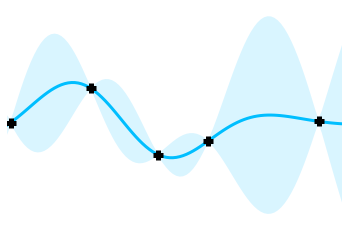

In [15]:
with torch.no_grad():
    # Initialize plot
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    fig = plt.figure()
    # Plot training data as black stars
    plt.scatter(train_x.numpy(), train_y.numpy(), marker="+", color="k", label='observations $\{(x_i, y_i)\}$', s=95, zorder=2000, lw=5)
#     plt.plot(ground_x.numpy(), ground_y.numpy(), linestyle="--", color=cool_colors[2], label='truth, $f(x)$', lw=3)
    # Plot predictive means as blue line
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), color=cool_colors[0], label='model, $\hat{y}(x)$', lw=3)
    # Shade between the lower and upper confidence bounds
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.15, color=cool_colors[0], edgecolor="none")
#     plt.ylim(the_ylims)
    plt.xlim([0, 1])
#     plt.xlabel('NPM feature space, $x$', fontsize=15)
#     plt.ylabel('property, $y$', fontsize=15)
    fig.patch.set_visible(False)
    plt.gca().axis('off')
    plt.yticks([])
    plt.xticks([])
#     plt.legend(fontsize=12)
    the_ylims = plt.gca().get_ylim()
    plt.savefig("gp_example_for_illustration.pdf")

In [13]:
the_ylims

(-1.1334793448448182, 1.52331041097641)

In [14]:
#### computing expected improvement objective for test points 
posterior = model(test_x)
mean = posterior.mean
sigma = posterior.variance.clamp_min(1e-9).sqrt()#.view(view_shape)
u = (mean - torch.max(train_y).expand_as(mean)) / sigma
normal = Normal(torch.zeros_like(u), torch.ones_like(u))
ucdf = normal.cdf(u)
updf = torch.exp(normal.log_prob(u))
ei = sigma * (updf + u * ucdf)

<ipython-input-35-bb24169925da>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  axs[1].plot(test_x.numpy(), 2*(ei.numpy())-3, 'g', label='Expected Improvement (EI)', lw=3, color=cool_colors[1])


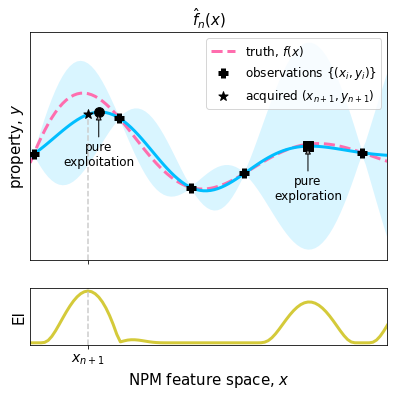

In [35]:
# Plotting figure 4 (a) 
with torch.no_grad():
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    
    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=[6.4, 1.2*4.8], sharex=True)
    # Plot training data as black stars
    axs[0].scatter(train_x.numpy(), train_y.numpy(), marker="+", color="k", label='observations $\{(x_i, y_i)\}$', s=95, zorder=2000, lw=5)
    axs[0].plot(ground_x.numpy(), ground_y.numpy(), linestyle="--", color=cool_colors[2], label='truth, $f(x)$', lw=3)
    # Plot predictive means as blue line
    axs[0].plot(test_x.numpy(), observed_pred.mean.numpy(), color=cool_colors[0], lw=3)
    # Shade between the lower and upper confidence bounds
    axs[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.15, color=cool_colors[0], edgecolor="none")
    axs[1].plot(test_x.numpy(), 2*(ei.numpy())-3, 'g', label='Expected Improvement (EI)', lw=3, color=cool_colors[1])
    
    xy_exploitation = (test_x[torch.argmax(observed_pred.mean)].numpy(), observed_pred.mean[torch.argmax(observed_pred.mean)].numpy())
    axs[0].scatter(xy_exploitation[0], xy_exploitation[1], color="k", s=95, marker="o", zorder=1000)
    ann = axs[0].annotate("pure\nexploitation",
                  xy=xy_exploitation, xycoords='data',
                  xytext=(xy_exploitation[0], xy_exploitation[1]-0.5), 
#                   xytext=(0.3, 1.0), 
                          textcoords='data',
                  size=12, va="center", ha="center",
                  arrowprops=dict(arrowstyle="-|>",
                                  fc=cool_colors[5], ec="k"), zorder=100000
                  )
    xy_exploration = (test_x[torch.argmax(observed_pred.stddev)].numpy(), observed_pred.mean[torch.argmax(observed_pred.stddev)].numpy())
    axs[0].scatter(xy_exploration[0], xy_exploration[1], color="k", s=95, marker="s", zorder=1000)
    ann = axs[0].annotate("pure\nexploration",
              xy=xy_exploration, xycoords='data',
              xytext=(xy_exploration[0], xy_exploration[1]-0.5), textcoords='data',
              size=12, va="center", ha="center",
              arrowprops=dict(arrowstyle="-|>",
                              fc=cool_colors[5], ec="k"), zorder=100000
              )
    axs[0].scatter(test_x[torch.argmax(ei)].numpy(), observed_pred.mean[torch.argmax(ei)].numpy(), color="k", label='acquired $(x_{n+1}, y_{n+1})$', s=95, marker="*", zorder=1000)
    axs[0].set_ylim(the_ylims)
    axs[1].set_xlabel('NPM feature space, $x$', fontsize=15)
    axs[0].set_ylabel('property, $y$', fontsize=15)
    axs[1].set_ylabel('EI', fontsize=15)
    for ax in axs:
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlim([0, 1])
    axs[1].axvline(x=test_x[torch.argmax(ei)].numpy(), linestyle="--", color="0.8")
    axs[0].plot([test_x[torch.argmax(ei)].numpy() for i in range(2)], [axs[0].get_ylim()[0], observed_pred.mean[torch.argmax(ei)].numpy()], linestyle="--", color="0.8")
    axs[0].set_title('$\hat{f}_{n}(x)$', fontsize=15)
    axs[0].set_xticks([test_x[torch.argmax(ei)].numpy()])
    axs[1].set_xticklabels(["$x_{n+1}$"])
    axs[1].tick_params(axis='x', which='major', labelsize=14)
    axs[0].legend(fontsize=12)#['Expected Improvement'])
    plt.savefig("gp_ei_iteration_n.pdf")

In [16]:
## update training set with new point (one with highest EI value)
new_train_x = torch.cat([train_x, test_x[torch.argmax(ei)].unsqueeze(0)])
new_train_y = f(new_train_x)# torch.sin(new_train_x * (2 * math.pi)) #+ torch.randn(new_train_x.size()) * math.sqrt(0.04)

In [13]:
## Fit the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = 1e-4 # sets the value to zero
likelihood.noise_covar.raw_noise.requires_grad = False # optimizer won't optimize noise hyper-parameter.
model = ExactGPModel(new_train_x, new_train_y, likelihood)
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(new_train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, new_train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

In [14]:
#### computing expected improvement objective for test points 
mean = posterior.mean
sigma = posterior.variance.clamp_min(1e-9).sqrt()#.view(view_shape)
u = (mean - torch.max(new_train_y).expand_as(mean)) / sigma
normal = Normal(torch.zeros_like(u), torch.ones_like(u))
ucdf = normal.cdf(u)
updf = torch.exp(normal.log_prob(u))
ei = sigma * (updf + u * ucdf)

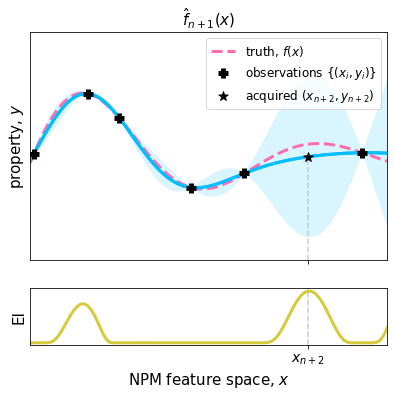

In [15]:
## Plotting figure 4(b)
model.eval()
likelihood.eval()
observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=[6.4, 1.2*4.8], sharex=True)
    # Plot training data as black stars
    # Plot training data as black stars
    axs[0].scatter(new_train_x.numpy(), new_train_y.numpy(), marker="+", color="k", label='observations $\{(x_i, y_i)\}$', s=95, zorder=2000, lw=5)
    axs[0].plot(ground_x.numpy(), ground_y.numpy(), linestyle="--", color=cool_colors[2], label='truth, $f(x)$', lw=3)
    # Plot predictive means as blue line
    axs[0].plot(test_x.numpy(), observed_pred.mean.numpy(), color=cool_colors[0], lw=3)
#     axs[0].scatter(new_train_x.numpy(), new_train_y.numpy(), marker="+", color="k", label='observation $(x_i, y_i)$', s=95, zorder=2000, lw=5)
#     axs[0].plot(ground_x.numpy(), ground_y.numpy(),'r--', label='True property')
    # Plot predictive means as blue line
    axs[0].plot(test_x.numpy(), observed_pred.mean.numpy(), color=cool_colors[0], lw=3)
    # Shade between the lower and upper confidence bounds
    axs[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.15, color=cool_colors[0], edgecolor="none")
    axs[0].set_ylim(the_ylims)
    axs[1].set_xlabel('NPM feature space, $x$', fontsize=15)
    axs[0].set_ylabel('property, $y$', fontsize=15)
    axs[1].set_ylabel('EI', fontsize=15)
    for ax in axs:
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlim([0, 1])
    axs[0].scatter(test_x[torch.argmax(ei)].numpy(), observed_pred.mean[torch.argmax(ei)].numpy(), color="k", label='acquired $(x_{n+2}, y_{n+2})$', s=95, marker="*", zorder=1000)
    axs[1].axvline(x=test_x[torch.argmax(ei)].numpy(), linestyle="--", color="0.8")
    axs[0].plot([test_x[torch.argmax(ei)].numpy() for i in range(2)], [axs[0].get_ylim()[0], observed_pred.mean[torch.argmax(ei)].numpy()], linestyle="--", color="0.8")
    axs[0].set_title('$\hat{f}_{n+1}(x)$', fontsize=15)
    axs[0].set_xticks([test_x[torch.argmax(ei)].numpy()])
    axs[1].set_xticklabels(["$x_{n+2}$"])
    axs[1].tick_params(axis='x', which='major', labelsize=14)
    axs[1].plot(test_x.numpy(), 2*(ei.numpy())-3, 'g', label='Expected Improvement (EI)', lw=3, color=cool_colors[1])
    axs[0].legend(fontsize=12)#['Expected Improvement'])
    plt.savefig("gp_ei_iteration_np1.pdf")